In [ ]:
import codecs
import errno
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm

In [51]:
TRAIN_PATH = '/Users/asaf/Downloads/wav'
TEST_PATH = '/Users/asaf/Downloads/wav 2'

## Preparing the data

In [38]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

def audio_to_spectogram(file_path):
    """
    This method transforms wav audio files into spectograms"
    :param path the path to the wav file
    """
    # Extract the mel-spectrogram
    y, sr = librosa.load(file_path)
    # Let's make and display a mel-scaled power (energy-squared) spectrogram
    mel_spec = librosa.feature.melspectrogram(y, sr=sr,n_mels=128,hop_length=1024,n_fft=2048)
    # Convert to log scale (dB). We'll use the peak power as reference.
    log_mel_spec = librosa.amplitude_to_db(mel_spec, ref=np.max)
    #make dimensions of the array even 128x1292
    log_mel_spec = np.resize(log_mel_spec,(128,644))
    print(log_mel_spec.shape)
    return log_mel_spec.flatten()

def preview_spectogram(file_path):
    y, sr = librosa.load(file_path)
    plt.figure(figsize=(12, 8))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    plt.subplot(4, 2, 1)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Linear-frequency power spectrogram')

(128, 644)


array([-80.      , -80.      , -80.      , ..., -77.455795, -63.89578 ,
       -61.196835], dtype=float32)

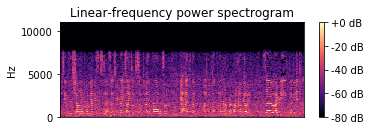

In [39]:
TEMP_PATH = TRAIN_PATH + '..'
file_path = TEMP_PATH + '/sample.wav'
preview_spectogram(file_path)
audio_to_spectogram(file_path)

In [106]:
import os
import glob

def extract_features(rootdir, min_labels=2, label_encoder):
    """
    :params rootdir root directory for the wav data in the form of <speaker>/<scene>/<wav_file>
    """
    data = dict()
    
    for root, dirs, _ in os.walk(rootdir):
        files = glob.glob(os.path.join(root, '*.wav'))
        for filename in files:
            spectogram = audio_to_spectogram(filename)
            speaker = filename.split(rootdir)[1].split('/')[1]
            data[speaker] = speakers[speaker] if speaker in speakers else []
            data[speaker].append[spectogram]
            
    for speaker in data:
        if len(data[speaker]) < min_labels:
            del data[speaker]
            
    return data

In [ ]:
def serialize_features(data, filename):
    """
    This method takes a dictionary and serialize it to a file
    :params data dictionary of speaker label and array of file path names (e.g. { 
         id123: ['path/to/file1', 'path/to/file2'] })
    :params filename file to serialized data
    """
    # todo
    
def load_features(filename):
    """
    This method loads a serialized file
    :params filename file of serialized data
    """
    # todo

In [ ]:
data = extract_features(rootdir)

TRAIN_FEATURES_FILE = 'train_features.pickle'
serialize_features(data, TRAIN_FEATURES_FILE)

TEST_FEATURES_FILE = 'test_features.pickle'
serialize_features(data, TEST_FEATURES_FILE)

## Dataset

In [ ]:
def get_positive_negative_sample(self, data_dict, size):
    """
    Returns an array of positive and negative samples
    :params data_dict dictionary to sample from
    :params size number of samples in the array to return
    :return array of tuples (original, positive, negative)

    """
    keys = list(data_dict.keys())
    res = []
    for i in range(size):
        # choose label randomly
        label_idx   = choose_index(keys)
        label       = keys[label_idx]

        # choose sample for this label
        orig_sample_idx = choose_index(data_dict[label])
        orig_sample     = data_dict[label][orig_sample_idx]

        # choose another label
        neg_label   = punctured_choice(keys, label_idx)
        # choose a sample for that label
        neg_sample  = np.random.choice(data[neg_label])

        # choose another sample for the original label
        pos_sample  = punctured_choice(data[label],orig_sample_idx)

        res.append( ((orig_sample, pos_sample, neg_sample), [1, 0]) )
    return res


def punctured_choice(arr, exclude_index):
    """
        Choose from array excluding a given index
        :params arr               a list from which the choice is made
        :params exclude_index     the position that cannot be returned
        :return                   an item from arr (not the value in :exclude_index)

    """
    idx = np.random.randint(len(arr)-1)
    if idx >= exclude_index:
        idx += 1
    return arr[idx]


def choose_index(arr):
    """
          Choose index in an array (rather than the value in this index)
          :params arr               a list from which the choice is made
          :return                   random number 0 <= x < len(arr)

    """
    return np.random.randint(len(arr))

In [ ]:
features_dict = load_features(features_file)
samplings = get_positive_negative_sample(features_dict, size=1000) # array of tupples [(orig, pos, neg), ...]

In [ ]:
from torch.utils.data import Dataset

class VoicesDataset(Dataset):
    """
    """
    
    def __init__(self, data):
        (pos_neg_samples, labels) = zip(*data)
        self.pos_neg_samples = pos_neg_samples # array of [(orig_sample, positive_sample, negative_sample), ...]
        # TODO: what about normalization of pos_neg_samples? see this example: https://gist.githubusercontent.com/branislav1991/f1a16e3d87389091d85699dbb1ba857d/raw/779a1b333017dd8645b1fc969f6826be374a742f/siamese.py
        self.labels = labels
        
    def __getitem__(self, index):
        (orig_sample, pos_sample, neg_sample) = self.pos_neg_samples[index]
        pos_neg_sample = (torch.tensor(orig_sample), torch.tensor(pos_sample), torch.tensor(neg_sample))
        label = torch.tensor(self.labels[index]) # label for positive sample is 1, and 0 for negative
        
        return (pos_neg_sample, label)
        
    def __len__(self):
        return len(self.labels)


In [ ]:
(pos_neg_samples, labels) = zip(*samplings) # unzip the tupples into an array of tupples of (orig, pos, neg) and array of labels

# Split data to train, test and validation sets
dataset = VoicesDataset(pos_neg_samples, labels)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

## The model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 64, 7)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(64, 128, 5)
        self.conv3 = nn.Conv2d(128, 256, 5)
        self.fc1 = nn.Linear(2304, 512) # TODO: check if 2304 is the right value ?!
        self.fc2 = nn.Linear(512, 2)
    
    def forward(self, data):
        res = []
        for i in range(2): # Siamese nets; sharing weights
            x = data[i]
            x = self.conv1(x)
            x = F.relu(x)
            x = self.pool1(x)
            x = self.conv2(x)
            x = F.relu(x)
            x = self.conv3(x)
            x = F.relu(x)
            
            x = x.view(x.shape[0], -1)
            x = self.fc1(x)
            res.append(F.relu(x))
            
        res = torch.abs(res[1] - res[0])
        res = self.fc2(res)
        return res

## Method to train and test the model

In [ ]:
def train(model, device, train_loader, epoch, optimizer):
    model.train()
    
    for batch_idx, (pos_neg_sample, label) in enumerate(train_loader):
        for i in range(len(pos_neg_sample)):
            pos_neg_sample[i] = pos_neg_sample[i].to(device)
            
        optimizer.zero_grad()
        output_positive = model(pos_neg_sample[:2]) 
        output_negative = model(pos_neg_sample[0:3:2]) 
        
        target = target.type(torch.LongTensor).to(device)
        target_positive = label[0] #torch.squeeze(label[:,0]) # TODO - are the dimensions right?
        target_negative = label[1] #torch.squeeze(label[:,1]) # TODO - is that right?
        
        loss_positive = F.cross_entropy(output_positive, target_positive)
        loss_negative = F.cross_entropy(output_negative, target_negative)
        
        loss = loss_positive + loss_negative
        loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, 
                                                                           batch_idx*batch_size, 
                                                                           len(train_loader.dataset), 
                                                                           100. * batch_idx*batch_size / len(train_loader.dataset), 
                                                                           loss.item()))

def test(model, device, test_loader):
    model.eval()
    
    with torch.no_grad():
        accurate_labels = 0
        all_labels = 0
        loss = 0
        
        for batch_idx, (data, target) in enumerate(test_loader):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            
            output_positive = model(data[:2]) # TODO - get from data
            output_negative = model(data[0:3:2]) # TODO - get from data

            target = target.type(torch.LongTensor).to(device)
            target_positive = torch.squeeze(target[:,0]) # TODO - get from data
            target_negative = torch.squeeze(target[:,1]) # TODO - get from data

            loss_positive = F.cross_entropy(output_positive, target_positive)
            loss_negative = F.cross_entropy(output_negative, target_negative)

            loss = loss + loss_positive + loss_negative

            accurate_labels_positive = torch.sum(torch.argmax(output_positive, dim=1) == target_positive).cpu()
            accurate_labels_negative = torch.sum(torch.argmax(output_negative, dim=1) == target_negative).cpu()

            accurate_labels = accurate_labels + accurate_labels_positive + accurate_labels_negative
            all_labels = all_labels + len(target_positive) + len(target_negative)
        
        accuracy = 100. * accurate_labels / all_labels
        print('Test accuracy: {}/{} ({:.3f}%)\tLoss: {:.6f}'.format(accurate_labels, all_labels, accuracy, loss))

## Inference

In [ ]:
def oneshot(model, device, data):
    model.eval()
    
    with torch.no_grad():
        for i in range(len(data)):
            data[i] = data[i].to(device)
      
        output = model(data)
        return torch.squeeze(torch.argmax(output, dim=1)).cpu().item()

## Train and run

In [ ]:
do_learn = True
save_frequency = 2
batch_size = 16
lr = 0.001
num_epochs = 10
weight_decay = 0.0001

In [ ]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [ ]:
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

    model = Net().to(device)

    if do_learn: # training mode
        train_loader = torch.utils.data.DataLoader(BalancedMNISTPair('../data', train=True, download=True, transform=trans), batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(BalancedMNISTPair('../data', train=False, download=True, transform=trans), batch_size=batch_size, shuffle=False)

        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        for epoch in range(num_epochs):
            train(model, device, train_loader, epoch, optimizer)
            test(model, device, test_loader)
            if epoch & save_frequency == 0:
                torch.save(model, 'siamese_{:03}.pt'.format(epoch))
    else: # prediction
        prediction_loader = torch.utils.data.DataLoader(BalancedMNISTPair('../data', train=False, download=True, transform=trans), batch_size=1, shuffle=True)
        model.load_state_dict(torch.load(load_model_path))
        data = []
        data.extend(next(iter(prediction_loader))[0][:3:2])
        same = oneshot(model, device, data)
        if same > 0:
            print('These two images are of the same number')
        else:
            print('These two images are not of the same number')


if __name__ == '__main__':
    main()